In [1]:
from pathlib import Path
import pandas as pd
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertModel
import torch
from sklearn.decomposition import PCA

/var/folders/9s/9tdd0tsn605550f4gnccqm9h0000gn/T/ipykernel_12813/501307540.py:3: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport


## Henter alle csv-filene fra mappen og gjør om til en pandas dataframe

In [2]:
nums_of_columns = []
csv_dir_path = Path('name_of_csv_files')  
liste_av_dfs = []
for csv_file in csv_dir_path.glob('*.csv'):
    df = pd.read_csv(csv_file)
    liste_av_dfs.append(df)
    nums_of_columns.append(len(df.columns)) 

## Finner antall felles kolonner for alle byggesøknadene

In [3]:
felles_kolonner = set(liste_av_dfs[0].columns)
for df in liste_av_dfs[1:]:
    felles_kolonner = felles_kolonner.intersection(set(df.columns))

antall_felles_attributter = len(felles_kolonner)
#print(f"Antall felles attributter for alle DataFrames: {antall_felles_attributter}")

## Bruker pandasProfiling-pakken til å se på forskjellig statistikk for datasettet

In [7]:
combined_dataframe_hele_datasett = pd.concat(liste_av_dfs, ignore_index=True)


In [5]:
#profile_hele_datasett = ProfileReport(combined_dataframe_hele_datasett)
#profile_hele_datasett

## Visualiserer hvor mange verdier som mangler per kolonne i datasettet

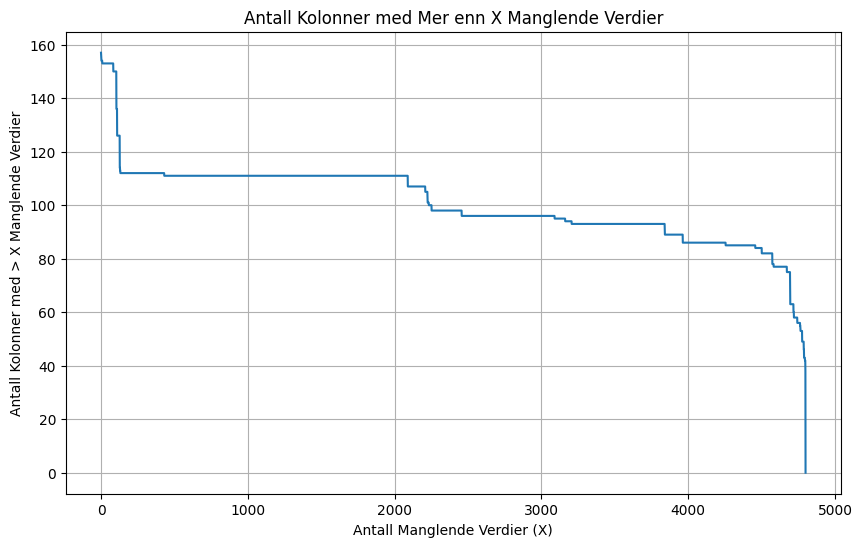

In [8]:
missing_values_count = combined_dataframe_hele_datasett.isna().sum()

## Maksimalt antall manglende verdier i en kolonne
max_missing = missing_values_count.max()

## Beregne antall kolonner med mer enn 'x' manglende verdier for hvert 'x'
columns_count_with_more_than_x_missing = [len(missing_values_count[missing_values_count > x]) for x in range(max_missing + 1)]

## Plotte grafen
plt.figure(figsize=(10, 6))
plt.plot(columns_count_with_more_than_x_missing)
plt.title('Antall Kolonner med Mer enn X Manglende Verdier')
plt.xlabel('Antall Manglende Verdier (X)')
plt.ylabel('Antall Kolonner med > X Manglende Verdier') # Invertere x-aksen for å få en synkende graf
plt.grid(True)
plt.show()

## Fjerner alle kolonner med flere enn 500 missing values og kolonner som inneholder én unik verdi

In [9]:
# Telle antall manglende verdier i hver kolonne
missing_values_count = combined_dataframe_hele_datasett.isna().sum()

# Identifiser kolonner med mer enn 500 manglende verdier
columns_to_drop = missing_values_count[missing_values_count > 500].index

# Fjerne disse kolonnene fra DataFrame
combined_dataframe_hele_datasett_treshold_500 = combined_dataframe_hele_datasett.drop(columns=columns_to_drop)

# Finner kolonner med kun én unik verdi
columns_with_single_value = combined_dataframe_hele_datasett_treshold_500.columns[combined_dataframe_hele_datasett_treshold_500.nunique() <= 1]

# Fjerne disse kolonnene fra DataFrame
combined_dataframe_hele_datasett_treshold_500 = combined_dataframe_hele_datasett_treshold_500.drop(columns=columns_with_single_value)

## Bruker BERT på "beskrivelse av tiltak med følgebrev". Dette er en kolonne med naturlig språk som verdi. BERT-algoritmen vil gjøre denne tekstrengen om til et array av tallverdier.

In [10]:
combined_dataframe_hele_datasett_treshold_500['beskrivelseAvTiltak_foelgebrev'] = combined_dataframe_hele_datasett_treshold_500['beskrivelseAvTiltak_foelgebrev'].fillna('').astype(str)

# Last inn BERT tokenizer og modell
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Funksjon for å konvertere tekst til BERT embeddings
def get_bert_embeddings(text):
    # Tokenize teksten og konverter til tensor
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512)
    # Få BERT embeddings
    with torch.no_grad():
        outputs = model(**inputs)
    # Ta gjennomsnittet av token embeddings for å få en enkelt vektor for setningen
    return outputs.last_hidden_state.mean(dim=1)[0].numpy()

# Anvend funksjonen på tekstkolonnen
bert_embeddings = combined_dataframe_hele_datasett_treshold_500['beskrivelseAvTiltak_foelgebrev'].apply(get_bert_embeddings)

# Konverter listen av embeddings til en DataFrame
bert_df = pd.DataFrame(bert_embeddings.tolist())

## Reduserer antall verdier i det forrige arrayet til 10 verdier, da det blir for tungt å holde på med 768 verdier.

In [11]:
# Initialiser PCA, velg for eksempel de 50 første hovedkomponentene
pca = PCA(n_components=10)

# Utfør PCA på BERT-embeddings
reduced_embeddings = pca.fit_transform(bert_df)

# Konverter de reduserte dataene tilbake til en DataFrame
reduced_bert_df = pd.DataFrame(reduced_embeddings)

# Kombinerer BERT-verdiene med den originale datarammen

combined_df_reduced_bert = pd.concat([combined_dataframe_hele_datasett_treshold_500.reset_index(drop=True), reduced_bert_df.reset_index(drop=True)], axis=1)


In [12]:
# Finn antall kolonner som inneholder minst én NaN verdi
num_columns_with_missing_values = combined_df_reduced_bert.isna().any().sum()

print(f"Antall kolonner med manglende verdier: {num_columns_with_missing_values}")

Antall kolonner med manglende verdier: 32


## Setter manuelt inn verdier for missing values nå

In [13]:
# Begynner med kolonner som skal fylles med en tom streng 
# Liste over kolonnenavn hvor NaN-verdier skal erstattes med tomme strenger
columns_to_replace = ['eiendomByggested_0_adresse_poststed', 
                      'eiendomByggested_0_adresse_adresselinje1', 
                      'eiendomByggested_0_adresse_postnr', "beskrivelseAvTiltak_type_type_kodeverdi", "beskrivelseAvTiltak_type_type_kodebeskrivelse", "rammebetingelser_plan_gjeldendePlan_plantype_kodebeskrivelse"]

# Erstatt NaN-verdier med tomme strenger i de spesifikke kolonnene
for column in columns_to_replace:
    combined_df_reduced_bert[column].fillna('', inplace=True)

# Vis resultatet for kontroll
print(combined_df_reduced_bert[columns_to_replace].head())

  eiendomByggested_0_adresse_poststed  \
0                              STOKKE   
1                                BODØ   
2                           KONGSBERG   
3                               HERRE   
4                             SANDNES   

  eiendomByggested_0_adresse_adresselinje1 eiendomByggested_0_adresse_postnr  \
0                        Helgerødsletta 68                            3160.0   
1                          Kvernhusveien 1                            8070.0   
2                            Bregneveien 3                            3615.0   
3                             Skoleåsen 47                            3965.0   
4                     General Ruges vei 4E                            4309.0   

  beskrivelseAvTiltak_type_type_kodeverdi  \
0                    bruksendringhoveddel   
1                    bruksendringhoveddel   
2                    bruksendringhoveddel   
3                        tilbyggunder50m2   
4                        tilbyggunder50m2   

 

In [14]:
# Går så over til de kolonnene som fylles med false eller true verdier. Dette avhenger av hvorvidt det er ubalanse mellom verdiene i kolonnene fra før.
# Liste over kolonnenavn hvor NaN-verdier skal erstattes med tomme strenger
columns_to_replace = ["rammebetingelser_plassering_konfliktHoeyspentkraftlinje", "rammebetingelser_kravTilByggegrunn_miljoeforhold", "rammebetingelser_kravTilByggegrunn_skredutsattOmraade", "rammebetingelser_kravTilByggegrunn_flomutsattOmraade", "rammebetingelser_avloep_tinglystErklaeringSpecified", "rammebetingelser_avloep_utslippstillatelseSpecified", "rammebetingelser_avloep_installereVannklosettSpecified", "rammebetingelser_arealdisponering_tomtearealSomTrekkesFraSpecified", "rammebetingelser_adkomst_nyeEndretAdkomst"]

# Erstatt NaN-verdier med tomme strenger i de spesifikke kolonnene
for column in columns_to_replace:
    combined_df_reduced_bert[column].fillna(False, inplace=True)



In [15]:
# Fjerner nå de radene som har missing values, ettersom det er få av dem og det er vanskelig å putte inn en annen verdi.  

# Liste over kolonnenavn hvor rader med NaN-verdier skal fjernes
columns_to_check = ['rammebetingelser_arealdisponering_tomtearealByggeomraadeSpecified', 
                    'rammebetingelser_arealdisponering_tomtearealBeregnetSpecified', 
                    'rammebetingelser_arealdisponering_beregnetMaksByggearealSpecified', "rammebetingelser_arealdisponering_arealBebyggelseEksisterendeSpecified", "rammebetingelser_arealdisponering_arealBebyggelseSomSkalRivesSpecified", "rammebetingelser_arealdisponering_arealBebyggelseNyttSpecified", "rammebetingelser_arealdisponering_parkeringsarealTerrengSpecified", "rammebetingelser_arealdisponering_arealSumByggesakSpecified", "rammebetingelser_arealdisponering_beregnetGradAvUtnyttingSpecified", "rammebetingelser_avloep_overvannTerreng", "rammebetingelser_avloep_overvannAvloepssystemSpecified", "rammebetingelser_plassering_bekreftetInnenforByggegrense"]

# Fjern rader med NaN-verdier i de angitte kolonnene
combined_df_reduced_bert = combined_df_reduced_bert.dropna(subset=columns_to_check)

In [16]:
# Går så over til 
# Liste over kolonnenavn hvor NaN-verdier skal erstattes med tomme strenger
columns_to_replace = ["rammebetingelser_plassering_minsteAvstandNabogrense"]

# Erstatt NaN-verdier med tomme strenger i de spesifikke kolonnene
for column in columns_to_replace:
    combined_df_reduced_bert[column].fillna(0, inplace=True)

In [ ]:
#profile_hele_datasett_treshold_500_no_uniform_values_combined_df_reduced_bert= ProfileReport(combined_df_reduced_bert)
#profile_hele_datasett_treshold_500_no_uniform_values_combined_df_reduced_bert

In [17]:
##Fjerner de to siste kolonnene som har missing values 

# Finn kolonnene som inneholder minst én NaN verdi
columns_with_missing_values = combined_df_reduced_bert.columns[combined_df_reduced_bert.isna().any()].tolist()

# Fjern disse kolonnene fra DataFrame
combined_df_reduced_bert = combined_df_reduced_bert.drop(columns=columns_with_missing_values)

# Vis resultatet for kontroll
print(combined_df_reduced_bert.head())

  eiendomByggested_0_adresse_adresselinje1 eiendomByggested_0_adresse_postnr  \
0                        Helgerødsletta 68                            3160.0   
1                          Kvernhusveien 1                            8070.0   
2                            Bregneveien 3                            3615.0   
3                             Skoleåsen 47                            3965.0   
4                     General Ruges vei 4E                            4309.0   

  eiendomByggested_0_adresse_poststed  \
0                              STOKKE   
1                                BODØ   
2                           KONGSBERG   
3                               HERRE   
4                             SANDNES   

   eiendomByggested_0_eiendomsidentifikasjon_kommunenummer  \
0                                               3804         
1                                               1804         
2                                               3006         
3                       

## Ferdig med EDA og lagrer dataframen til CSV

In [18]:
combined_df_reduced_bert.to_csv('ferdig_dataframe.csv', index=False)